# Data exploration notebook

A simple notebook just to look at the data we got and start to experiment around.

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from src.scoring import rps
from src.strategy import get_weight_from_predictions

In [3]:
np.random.seed(0)

In [4]:
RELOAD = False
START_TEST = "2019-01-01"

In [5]:
#assets = pd.read_csv("../data/assets_m6.csv")
universe = pd.read_csv("../data/M6_Universe.csv", index_col=0)
universe = universe[universe.symbol != "IEFM.L"].copy() #  has data issues

In [6]:
def get_company_name(ticker_symbol, universe=universe):
    return universe[universe.symbol==ticker_symbol].name.iloc[0]

In [7]:
universe.head()

,class,symbol,name,GICS_sector/ETF_type,GICS_industry/ETF_subtype
id,,,,,
1,Stock,ABBV,AbbVie,Health Care,Pharmaceuticals
2,Stock,ACN,Accenture,Information Technology,IT Consulting & Other Services
3,Stock,AEP,American Electric Power,Utilities,Electric Utilities
4,Stock,AIZ,Assurant,Financials,Multi-line Insurance
5,Stock,ALLE,Allegion,Industrials,Building Products


In [8]:
universe.groupby("class")["name"].count()

class
ETF      49
Stock    50
Name: name, dtype: int64

In [9]:
universe.groupby(["class", "GICS_sector/ETF_type"])["name"].count()

class  GICS_sector/ETF_type  
ETF    Commodities                3
       Equities                  36
       Fixed Income               9
       Volatility                 1
Stock  Communication Services     3
       Consumer Discretionary     6
       Consumer Staples           3
       Energy                     2
       Financials                 7
       Health Care                6
       Industrials                7
       Information Technology     7
       Materials                  3
       Real Estate                3
       Utilities                  3
Name: name, dtype: int64

In [10]:
universe.groupby(["class", "GICS_industry/ETF_subtype"])["name"].count()

class  GICS_industry/ETF_subtype            
ETF    Credit-Europe                             2
       Credit-US                                 2
       Diversified Commodity                     1
       Equity Style-Europe                       2
       Equity Style-North America                3
       Govt-Europe                               1
       Govt-Global                               1
       Govt-US                                   3
       Large Cap-Asia                            7
       Large Cap-Europe                          4
       Large Cap-Global                          1
       Large Cap-North America                   2
       Large Cap-South America                   1
       Precious Metals                           2
       Sector-Global                             4
       Sector-US                                10
       Small Cap-Europe                          1
       Small Cap-North America                   1
       US                            

In [11]:
if RELOAD:
    all_stocks_hist = pd.DataFrame()
    for iid in tqdm(universe.index):
        ticker = universe.loc[iid, "symbol"]
        stock = yf.Ticker(ticker)
        hist = stock.history(period="max")
        all_stocks_hist[ticker] = hist.stack()
    all_stocks_hist.to_pickle("../data/stocks_hist.pkl")
else:
    all_stocks_hist = pd.read_pickle("../data/stocks_hist.pkl")

20


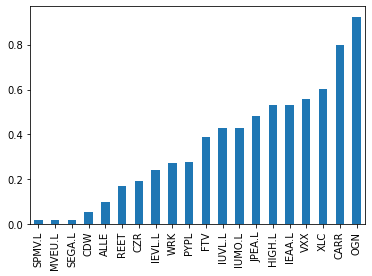

In [12]:
nan_fraction = all_stocks_hist.isna().mean().sort_values()
(nan_fraction[nan_fraction > 0]).plot.bar()
print(nan_fraction[nan_fraction > 0].shape[0])

In [13]:
closing_prices = all_stocks_hist.unstack(-1).swaplevel(axis=1)["Close"].bfill()  # backfilling price

<AxesSubplot:xlabel='Date'>

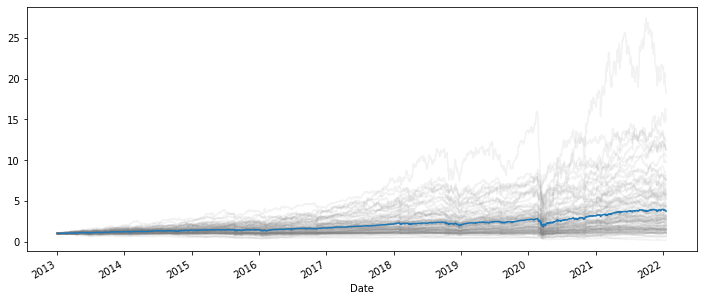

In [14]:
(closing_prices / closing_prices.iloc[0]).plot(legend=False, color="gray", alpha=0.1, figsize=(12, 5))
(closing_prices / closing_prices.iloc[0]).mean(axis=1).plot()

In [15]:
price_corr = closing_prices.corr()

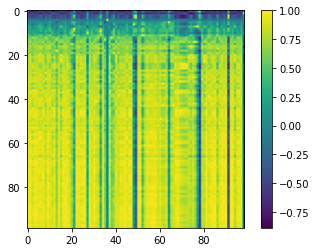

In [16]:
plt.imshow(price_corr.sort_values(price_corr.columns[0]))
plt.colorbar()

In [17]:
daily_returns = np.log(1 + closing_prices.pct_change().dropna())

In [18]:
monthly_returns = daily_returns.resample("MS").sum()
monthly_vol = closing_prices.resample("MS").std() / closing_prices.resample("MS").mean()

In [19]:
monthly_quintiles = monthly_returns.apply(lambda x: (x.rank(ascending=True) // 20 +1).clip(upper=5)).astype(int)

In [20]:
monthly_quintiles.head()

,ABBV,ACN,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,...,XLF,XLV,XLE,XLY,XLI,XLC,XLU,XLP,XLB,VXX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,5,4,4,5,3,5,3,4,1,5,...,4,5,5,4,4,3,4,5,3,4
2013-02-01,3,4,5,5,3,4,4,3,2,5,...,3,3,3,3,4,3,4,5,2,4
2013-03-01,5,3,4,5,3,2,5,3,4,5,...,5,5,4,5,4,3,5,5,4,4
2013-04-01,5,5,5,4,3,4,3,2,5,1,...,4,4,3,4,2,3,5,5,3,4
2013-05-01,1,3,1,4,3,4,5,4,2,4,...,5,3,4,4,5,3,1,1,4,4


In [21]:
test_set = monthly_quintiles.loc[START_TEST:].index
y_true = monthly_quintiles.loc[test_set]

In [22]:
prediction_random = pd.DataFrame(
    np.random.randint(1, 6, size=y_true.shape),
    index=y_true.index,
    columns=y_true.columns
)

In [23]:
y_true_class = pd.get_dummies(y_true.stack())
prediction_proba_random_1 = pd.get_dummies(prediction_random.stack())
prediction_proba_random_2 = pd.DataFrame(
    np.random.rand(*y_true_class.shape), 
    index=y_true_class.index,
    columns=y_true_class.columns
)
prediction_proba_random_2 = prediction_proba_random_2.div(prediction_proba_random_2.sum(axis=1), axis=0)
prediction_proba_equal = pd.DataFrame(
    0.2, 
    index=y_true_class.index,
    columns=y_true_class.columns
)

In [24]:
window_models = {}

for window in [12, 48]:
    df = pd.DataFrame({i: monthly_quintiles.shift(i+1).stack() for i in range(window)}).dropna()
    proba_window = df.stack().groupby(level=[0, 1]).value_counts().unstack(fill_value=0) / window
    proba_window = proba_window.loc[test_set]
    window_models[window] = proba_window

In [25]:
static = pd.get_dummies(monthly_quintiles.loc[:START_TEST].stack()).T.stack().mean(axis=1).unstack(0)
prediction_static = pd.DataFrame({d: static.stack() for d in test_set}).T.stack(0)
prediction_static.index.names = y_true_class.index.names

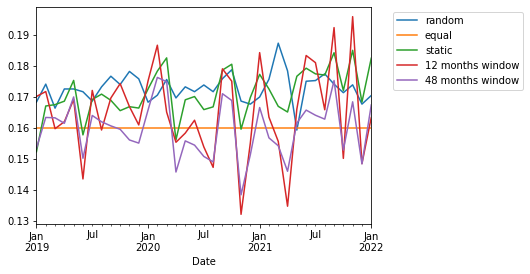

In [26]:
score_random_1 = rps(y_true_class, prediction_proba_random_1)
score_random_2 = rps(y_true_class, prediction_proba_random_2)
score_equal = rps(y_true_class, prediction_proba_equal)
score_static = rps(y_true_class, prediction_static)

ax = score_random_2.plot(label="random")
score_equal.plot(label="equal", ax=ax)
score_static.plot(label="static", ax=ax)

for w in window_models:
    score_window = rps(y_true_class, window_models[w])
    score_window.plot(label=f"{w} months window", ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1))

In [27]:
score_window.mean()

0.15973667796584462

In [28]:
score_equal.mean()

0.16000000000000006

In [29]:
(score_equal.mean() - score_window.mean()) / score_equal.mean()

0.0016457627134714916

Using a 48 months window barely beats the equal probability prediction! Probably no statistically significant difference.

<AxesSubplot:xlabel='Date'>

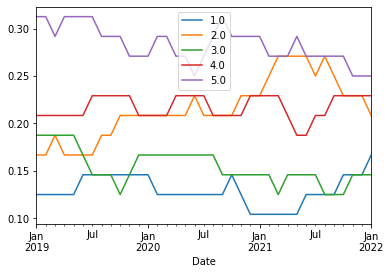

In [30]:
# an example
window_models[w].unstack(-1).swaplevel(axis=1)["AMZN"].plot()

Can we make a strategy out of this simple model?

In [31]:
best_prediction = window_models[48]

In [32]:
daily_test_index = closing_prices.loc[START_TEST:].index

In [33]:
market_returns = (1 + closing_prices.pct_change().loc[daily_test_index]).mean(axis=1)

In [34]:
portfolio_returns_k = pd.DataFrame()
for k in [1, 2, 3]:
    weights = get_weight_from_predictions(best_prediction, k)
    daily_weights = weights.resample("d").pad().reindex(daily_test_index).ffill()
    portfolio_returns_k[k] = (daily_weights * (1 + closing_prices.pct_change().loc[daily_test_index])).sum(axis=1)

In [35]:
# fit an actual model
window_len = 6
X = pd.concat([monthly_quintiles.shift(i+1).stack() for i in range(window_len)], axis=1).dropna()
y = monthly_quintiles.stack().reindex(X.index)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [37]:
X_train = X.unstack().loc[:START_TEST].stack().reset_index().drop("Date", axis=1)
X_test = X.unstack().loc[START_TEST:].stack().reset_index().drop("Date", axis=1)
y_train = y.unstack().loc[:START_TEST].stack()
y_test = y.unstack().loc[START_TEST:].stack()

In [38]:
X_train["level_1"] = X_train["level_1"].astype("category")
X_test["level_1"] = X_test["level_1"].astype("category")

In [39]:
mdl_lgbm = LGBMClassifier(n_estimators=40, max_depth=4, learning_rate=0.01)
mdl_lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, max_depth=4, n_estimators=40)

In [40]:
mdl_lgbm.score(X_train, y_train)

0.3545906829488919

In [41]:
mdl_lgbm.score(X_test, y_test)

0.3063063063063063

In [42]:
proba_lgbm = pd.DataFrame(mdl_lgbm.predict_proba(X_test), index=y_test.index, columns=range(1, 6))

In [43]:
portfolio_returns_k["market"] = market_returns

In [44]:
weights = get_weight_from_predictions(proba_lgbm, 5)
daily_weights = weights.resample("d").pad().reindex(daily_test_index).ffill()
portfolio_returns_k["lgbm"] = (daily_weights * (1 + closing_prices.pct_change().loc[daily_test_index])).sum(axis=1)

In [45]:
X_dummy = pd.concat([X.reset_index(drop=True), pd.get_dummies(X.reset_index()["level_1"])], axis=1)
X_dummy.index = X.index

In [46]:
X_train_dummy = X_dummy.unstack().loc[:START_TEST].stack().reset_index(drop=True)
X_test_dummy = X_dummy.unstack().loc[START_TEST:].stack().reset_index(drop=True)
X_train_dummy.columns = X_train_dummy.columns.astype(str)
X_test_dummy.columns = X_test_dummy.columns.astype(str)

In [47]:
mdl_forest = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_leaf=15, random_state=0)
mdl_forest.fit(X_train_dummy, y_train)

RandomForestClassifier(min_samples_leaf=15, n_estimators=1000, random_state=0)

In [48]:
mdl_forest.score(X_train_dummy, y_train)

0.3354439921604101

In [49]:
mdl_forest.score(X_test_dummy, y_test)

0.3202293202293202

In [50]:
proba_forest = pd.DataFrame(mdl_forest.predict_proba(X_test_dummy), index=y_test.index, columns=range(1, 6))

In [51]:
weights = get_weight_from_predictions(proba_forest, 5)
daily_weights = weights.resample("d").pad().reindex(daily_test_index).ffill()
portfolio_returns_k["random forest"] = (daily_weights * (1 + closing_prices.pct_change().loc[daily_test_index])).sum(axis=1)

In [52]:
proba_mean = (proba_forest + proba_lgbm) / 2

In [53]:
weights = get_weight_from_predictions(proba_mean, 5)
daily_weights = weights.resample("d").pad().reindex(daily_test_index).ffill()
portfolio_returns_k["ensemble"] = (daily_weights * (1 + closing_prices.pct_change().loc[daily_test_index])).sum(axis=1)

<AxesSubplot:xlabel='Date'>

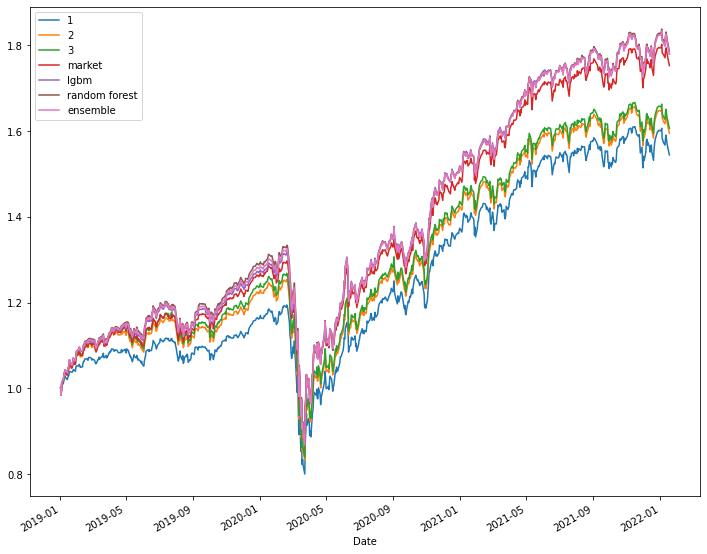

In [54]:
portfolio_returns_k.cumprod().plot(figsize=(12, 10))

In [55]:
(portfolio_returns_k.resample("MS").prod() - 1).mean().sort_values().pct_change()

1                     NaN
2                0.073938
3                0.015203
market           0.163974
lgbm             0.032015
ensemble         0.003973
random forest    0.006632
dtype: float64

In [56]:
score_equal = rps(y_true_class, prediction_proba_equal)
score_lgbm = rps(y_true_class, proba_lgbm)
score_forest = rps(y_true_class, proba_forest)
score_mean = rps(y_true_class, proba_mean)

<AxesSubplot:xlabel='Date'>

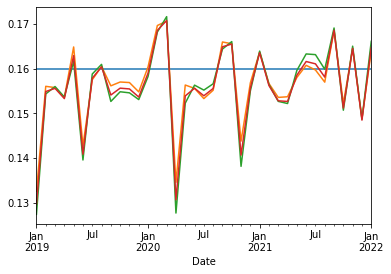

In [57]:
score_equal.plot()
score_lgbm.plot()
score_forest.plot()
score_mean.plot()

<AxesSubplot:xlabel='Date'>

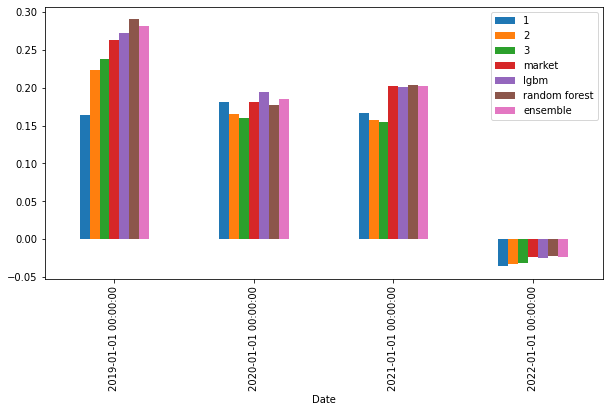

In [58]:
(portfolio_returns_k.resample("YS").prod()-1).plot.bar(figsize=(10, 5))

In [59]:
# add features
X = pd.concat([
    X, 
    pd.concat([monthly_returns.shift(i+1).stack() for i in range(window_len)], axis=1).dropna(),
    pd.concat([monthly_vol.shift(i+1).stack() for i in range(window_len)], axis=1).dropna(),
], axis=1)

In [60]:
X.columns = range(len(X.columns))

In [61]:
X_dummy = pd.concat([X.reset_index(drop=True), pd.get_dummies(X.reset_index()["level_1"])], axis=1)
X_dummy.index = X.index

X_train_dummy = X_dummy.unstack().loc[:START_TEST].stack().reset_index(drop=True)
X_test_dummy = X_dummy.unstack().loc[START_TEST:].stack().reset_index(drop=True)
X_train_dummy.columns = X_train_dummy.columns.astype(str)
X_test_dummy.columns = X_test_dummy.columns.astype(str)

In [62]:
mdl_forest = RandomForestClassifier(n_estimators=2000, min_samples_leaf=100, random_state=0)
mdl_forest.fit(X_train_dummy, y_train)
mdl_forest.score(X_train_dummy, y_train), mdl_forest.score(X_test_dummy, y_test)

(0.31840796019900497, 0.36663936663936664)

In [63]:
proba_forest = pd.DataFrame(mdl_forest.predict_proba(X_test_dummy), index=y_test.index, columns=range(1, 6))

weights = get_weight_from_predictions(proba_forest, 5)
daily_weights = weights.resample("d").pad().reindex(daily_test_index).ffill()
portfolio_returns_k["random forest augmented"] = (daily_weights * (1 + closing_prices.pct_change().loc[daily_test_index])).sum(axis=1)

<AxesSubplot:xlabel='Date'>

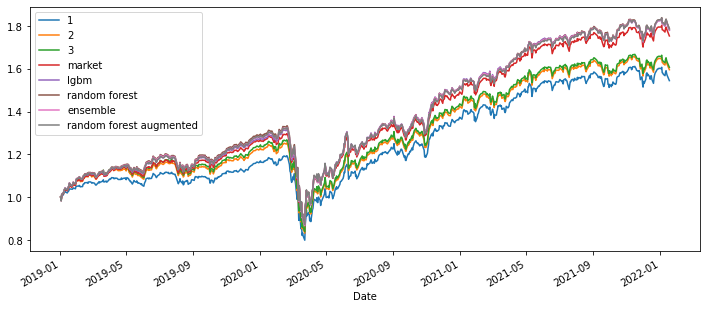

In [64]:
portfolio_returns_k.cumprod().plot(figsize=(12, 5))

In [65]:
portfolio_returns_k.prod().sort_values().pct_change()

1                               NaN
2                          0.032991
3                          0.006997
market                     0.091076
lgbm                       0.015195
ensemble                   0.001069
random forest augmented    0.002459
random forest              0.000475
dtype: float64